# **MIE1513: Final Project** 
### Jeong Cheol Seok 999737236
### Submission date: April 20, 2020 at 23:59pm

-------------

## Academic Integrity Declaration:
In submitting this assessment, I confirm that my conduct during this project adheres to the Code of Behaviour on Academic Matters. I confirm that I have not acted in such a way that would constitute cheating, misrepresentation, or unfairness, including but not limited to, using unauthorized aids and assistance, impersonating another person, and committing plagiarism. I pledge upon my honour that I have not violated the Faculty of Applied Science & Engineering’s Honour Code during this assessment.

-------------


## Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import re, nltk
import string
import html
from html.parser import HTMLParser

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from collections import Counter

#Operation
import operator

from tqdm import tqdm_notebook as tqdm


# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Graph Function

In [4]:
#Count plot graph function
def countplot(x, data, order ):
    plt.figure(figsize=(18,6))
    sns.set(style="darkgrid")
    ax= sns.countplot(x=x, data=data, order = order)
    plt.tight_layout()
    
def boxplot(x,y,data,order, rotate_text):
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(x= x, y = y, data = data, order = order, showfliers=False)
    if rotate_text == 1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()    
    
def grouped_bargraph (result, title):
    labels = result.columns
    num_labels = result.shape[1]
    
    x = np.arange((result.shape[0]))
    width = 0.7/num_labels
    
    fig,ax = plt.subplots(figsize = (10,5))
    
    for idx in range(num_labels):
        rect = ax.bar(x + width*idx, result.iloc[:,idx], width)

    ax.set_ylabel('Scores')
    ax.set_title(title)
    
    if num_labels == 2:
        ax.set_xticks(x + width/(num_labels))
    else:
        ax.set_xticks(x + width)
    
    ax.set_xticklabels(result.index)

    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
        
    

## Part 1: Data Loading

### (a) Load the provided dataset (reddit_data.json)

In [5]:
import pandas as pd

In [6]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [7]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


### (b)	Generate your unique subset of the data

**Make sure you update unique_string with your email address**

In [8]:
# DO NOT CHANGE THE FUNCTION BELOW
def getMySubreddits(data, my_str):
    assert my_str != "", "You must fill in your unique string"
    import random
    subreddits = sorted(data["subreddit"].unique().tolist())
    rng = random.Random(my_str)
    return rng.sample(subreddits, 4)

In [9]:
# Fill in your UofT email in the variable unique_string below
unique_string = "jc.seok@mail.utoronto.ca" 
my_subreddits = getMySubreddits(data_all, unique_string)
print("My subreddits:", my_subreddits)

My subreddits: ['gaming', 'programming', 'WTF', 'nfl']


In [10]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

In [11]:
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
6,abcv8x,suen05csus,1546300931,gaming,Xbox 1 s controller not discovered via bluetoo...,7,3,Title says it all...\n\nXbox 1 s controller no...,https://www.reddit.com/r/gaming/comments/abcv8...
8,abcvdf,IAmNightbreed,1546300952,gaming,The local Walmart did not sell even one copy o...,24,43,,https://i.redd.it/30cad4s3dp721.jpg
21,abcwko,FACESS,1546301171,gaming,What is the best wireless headset for PS4? I k...,6,2,,https://www.reddit.com/r/gaming/comments/abcwk...
22,abcwmu,JJ-GAMESTER,1546301182,gaming,Happy New Year Gamers,20,50,,https://i.redd.it/gusnviisdp721.jpg


## Part 2: Exploratory Data Analysis 

In NLP tasks, EDA is extremely important as it helps us to understand our data better which will ultimately result in better feature selection and model performance. Therefore, for each provided variables in the data, we will analyze to determine which variables important for classification tasks.

In [12]:
data = data.reset_index(drop=True)

## 2.1 Target Variable

The column of subreddit in the dataset is the target variable or the classes of this classification task. For this project, the subreddits that are analyzed are as follows:
* Gaming - Subreddit for anything related to video games
* Programming - Subreddit for programming
* NFL - Subreddit for NFL
* WTF - Subreddit for things that make us say what the f**k

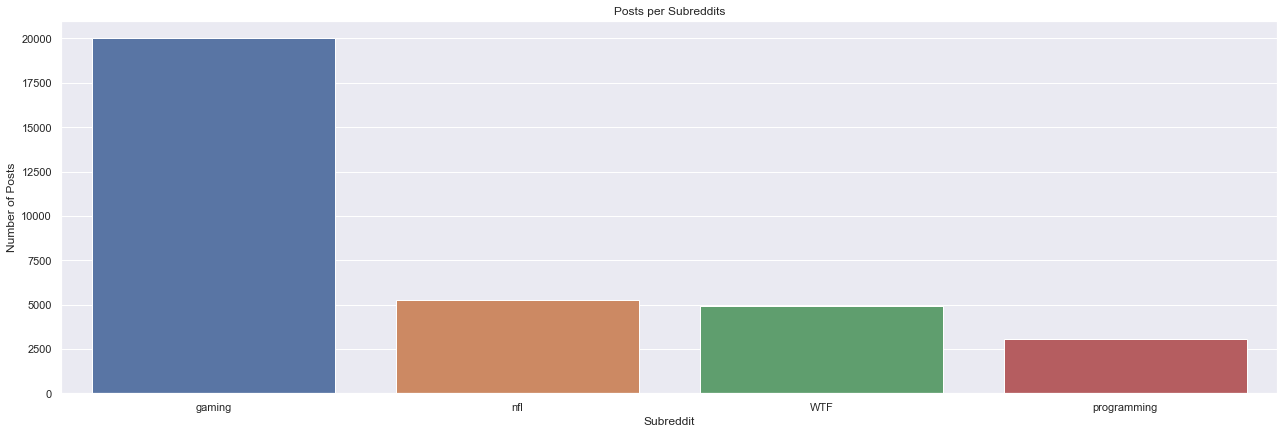

In [13]:
#Sub Reddit Distribution
index = data['subreddit'].value_counts().index

countplot('subreddit', data, order = index)
plt.title("Posts per Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Number of Posts")
plt.show()

The data is currently imbalanced as gaming have the sustantially large data compared to other subreddits.

## 2.2 Features

### ID

ID is simply an unique identifier for the post. This feature does not help with our classification tasks as all posts have their own unique id. Therefore, ID is removed for classification.

### Author

Author is simply the author or the user of the post. the Adding the variable author may be useful since it is likely that one user that posted in a specific subreddit would post again in the same subreddit. However, the pool of users to analyze from are going to be sparse and may not be informative most of the times due to users posting in multiple subreddits in the list and users that posted once. In order to implement the author as the variable, we could need one hot encoding which would increase our feature size by heavily. 

Also, when the post is removed or deleted, the author also gets removed from the dataset. Therefore, author will be removed for this classification.



In [72]:
data['author'].value_counts()

[deleted]               7234
davidk01                  90
vonheisenberg             77
rhydon_my_steelix         56
ValKilmsnipsinBatman      51
JaguarGator9              38
one_eyed_golfer           30
King1003                  27
dad_selfie                27
javinpaul                 26
247labsca                 26
DreamedJewel58            26
Extra-High-Elf            26
MattyT7                   25
chahley1                  25
NFL_Mod                   24
fagnerbrack               24
unitas42                  23
Torvusil                  23
suryarose                 22
speckz                    22
Generaljamie              21
Nuclear_Faggot            21
FrankSchmidtTinyLabs      21
ohnoitisigod              21
cosmonautjeff             20
West_Package              20
Tuitonbooksandrent        20
sip-em_bears              20
priceless3446             19
                        ... 
karm4wh0r3                 1
Rahul1872                  1
sellmyhouse010             1
infuturex9    

In [69]:
data[data['author'] == 'davidk01']['subreddit'].unique()

array(['programming'], dtype=object)

The username, davidk01 has the largest number of postings in the dataset. This user created 90 postings on programming subreddit.

In [70]:
data[data['author'] == 'vonheisenberg']['subreddit'].unique()

array(['nfl'], dtype=object)

The username, vonheisenberg has the second largest number of postings in the dataset. This user created 77 postings on NFL subreddit.

In [79]:
data[data['author'] == 'rhydon_my_steelix']['subreddit'].unique()

array(['nfl'], dtype=object)

The username, data has the third largest number of postings in the dataset. This user created 56 postings on NFL subreddit.

In [80]:
(data['author'].value_counts()==1).sum()

16970

There are authors that possess strong preference, and adding these authors would definitely allow the model to identify the subreddit of the postings. However, based on the number above, there are 16970 out of 19664 users that have only posted once. This means that the 16970 data won't find the author variable useful. Therefore, author is excluded in our study.

### Created_UTC

The variable created_utc is the UTC timestamp of the post. This is not informative, because the extracted data are from January 2019 which means there are no differentiating aspect between the classes for the timestamp. Therefore, created_utc is also removed from the data.

### TItle

The variable, title is the title of the post. This is considered one of the most important feature for determining the classes. 

In [15]:
data['title'].head()

0    What are some game games to enjoy on a low-end...
1    Xbox 1 s controller not discovered via bluetoo...
2    The local Walmart did not sell even one copy o...
3    What is the best wireless headset for PS4? I k...
4                                Happy New Year Gamers
Name: title, dtype: object

### Cleaning Data

Currently, the data has too much 'noise'. Therefore, the data will be cleaned with the procedure below:

1. Lowercase the text - The same words with either lower and upper casing will be considered differently in the model if the text casing aren't unified. 

2. Tokenize - Breaks the words in a sentence to a list. This is for data preprocessing.
2. Remove stopwords using the NLTK library - The stopwords do not help the model find the true context of the sentence.
3. Remove Punctuation - Punctuation does not contain much information or any relationship with the subreddits. 
4. Lemmatize the words - Lemmatize to brings the word to the actual word of the language which helps us to reduce the dimensions and groups the words with the same meaning.

In [16]:
#Functions for Data Cleaning
def lower_case(post):
    post = post.lower()
    return post

#Tokenization - Converting a sentence into list of words
def tokenization(post):
    post = re.split('\W+', post)
    return post

#Remove Stop words using nltk list 
def remove_stop_words(post):
    post = [word for word in post if word not in stop_nltk] 
    return post    

#Remove Punctuation
def remove_punc(post):
    post = [char for char in post if char not in string.punctuation]
    return post

#Lemmatize the words
wn = nltk.WordNetLemmatizer()

def lemmatizer(post):
    post = [wn.lemmatize(word) for word in post]
    return post    

In [17]:
stop_nltk = stopwords.words('english')

In [18]:
def clean_post(data):
    data = data.apply(lambda x: lower_case(x))
    data = data.apply(lambda x: tokenization(x))    
    data = data.apply(lambda x: remove_stop_words(x))   
    data = data.apply(lambda x: remove_punc(x)) 
    data = data.apply(lambda x: lemmatizer(x)) 
   
    return data

In [19]:
#Store the tokenized words in clean_title
data['clean_title'] = clean_post(data['title']) 

In [20]:
#Join the tokenized words into one string and store it in clean_title_joined
data['clean_title_joined'] = data['clean_title'].apply(lambda x: ' '.join(x))

In [21]:
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,clean_title,clean_title_joined
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...,"[game, game, enjoy, low, end, laptop]",game game enjoy low end laptop
1,abcv8x,suen05csus,1546300931,gaming,Xbox 1 s controller not discovered via bluetoo...,7,3,Title says it all...\n\nXbox 1 s controller no...,https://www.reddit.com/r/gaming/comments/abcv8...,"[xbox, 1, controller, discovered, via, bluetoo...",xbox 1 controller discovered via bluetooth win...
2,abcvdf,IAmNightbreed,1546300952,gaming,The local Walmart did not sell even one copy o...,24,43,,https://i.redd.it/30cad4s3dp721.jpg,"[local, walmart, sell, even, one, copy, releas...",local walmart sell even one copy release date ...
3,abcwko,FACESS,1546301171,gaming,What is the best wireless headset for PS4? I k...,6,2,,https://www.reddit.com/r/gaming/comments/abcwk...,"[best, wireless, headset, ps4, know, personal,...",best wireless headset ps4 know personal prefer...
4,abcwmu,JJ-GAMESTER,1546301182,gaming,Happy New Year Gamers,20,50,,https://i.redd.it/gusnviisdp721.jpg,"[happy, new, year, gamers]",happy new year gamers


There may be posts with titles that are completely removed from data cleaning. We will remove those, because without the title, there won't be enough information for the model to predict the correct classes.

In [22]:
#Size of data with empty value
len(data[data['clean_title_joined'] ==''])

171

In [23]:
#Drop rows with empty titles
drop_rows = data[data['clean_title_joined'] ==''].index
data.drop(drop_rows , inplace=True)
data = data.reset_index()

In [24]:
len(data[data['clean_title_joined'] ==''])

0

### Feature Extraction Method

For feature extraction method of the title, we will use TF-IDF and bag of words, and compare the results during modeling. Bag of words emphasize on the frequency while TF-IDF focuses on the frequency of the terms and the rareness of the terms throughout the dataset. Both of these methods are powerful, but easy to compute.

The top 2000 words are featurized due to computational limitation. 

#### Bag of Words

In [25]:
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

#Set max features to 2000
vectorizer = CountVectorizer(analyzer = "word", max_features = 2000)

train_data_features = vectorizer.fit_transform(data['clean_title_joined'])

train_data_features = train_data_features.toarray()

feature_names = vectorizer.get_feature_names()

title_BoW = pd.DataFrame(train_data_features, columns = feature_names)

In [26]:
title_BoW.head()

,000,10,100,1000,11,12,13,14,15,16,...,yes,yesterday,yet,young,younger,youtube,zelda,zero,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF-IDF

In [27]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Set max features to 2000
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, analyzer='word', max_features = 2000)

train_data_features = tf_vectorizer.fit_transform(data['clean_title_joined'])
train_data_features = train_data_features.toarray()

feature_names = tf_vectorizer.get_feature_names()

title_tf = pd.DataFrame(train_data_features, columns = feature_names)

In [28]:
title_tf.head()

,000,10,100,1000,11,12,13,14,15,16,...,yes,yesterday,yet,young,younger,youtube,zelda,zero,zombie,zone
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.339696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Cloud

Word cloud helps us to visualize which terms are frequently used in each classes. This helps us to identify some of the keywords that could be found in each classes.

In [29]:
def generate_wordcloud (data, subreddit):
    keywords = [x for x in data[data['subreddit']==subreddit]['clean_title_joined']]
    keywords = " ".join(keywords)
    
    wordcloud = WordCloud(width = 2000, height = 1000, max_words=500).generate(keywords)

    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Keywords of ' + subreddit)
    plt.axis("off")
    plt.show()

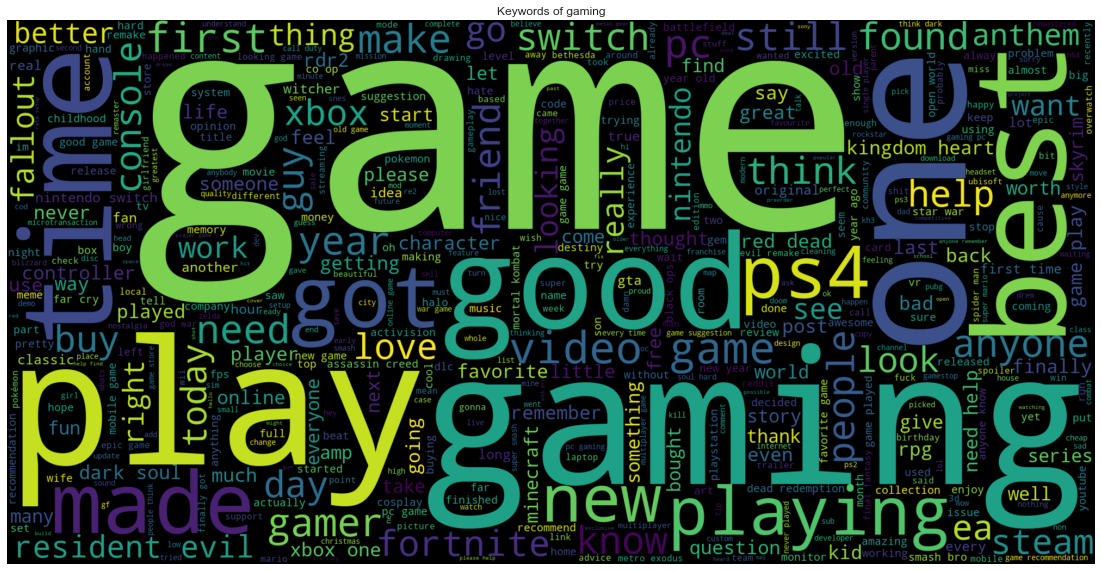

In [30]:
generate_wordcloud(data, 'gaming')

Some of the top keywords are "game", "play", and "gaming". The top keywords are definitely related to the subreddit, gaming. However, this may pose some issues, because terms like "game" and "play" are not only exclusive to the gaming subreddit. Other keywords like nintendo switch, ps4, fall out, resident evil are all specific to gaming subreddits.  

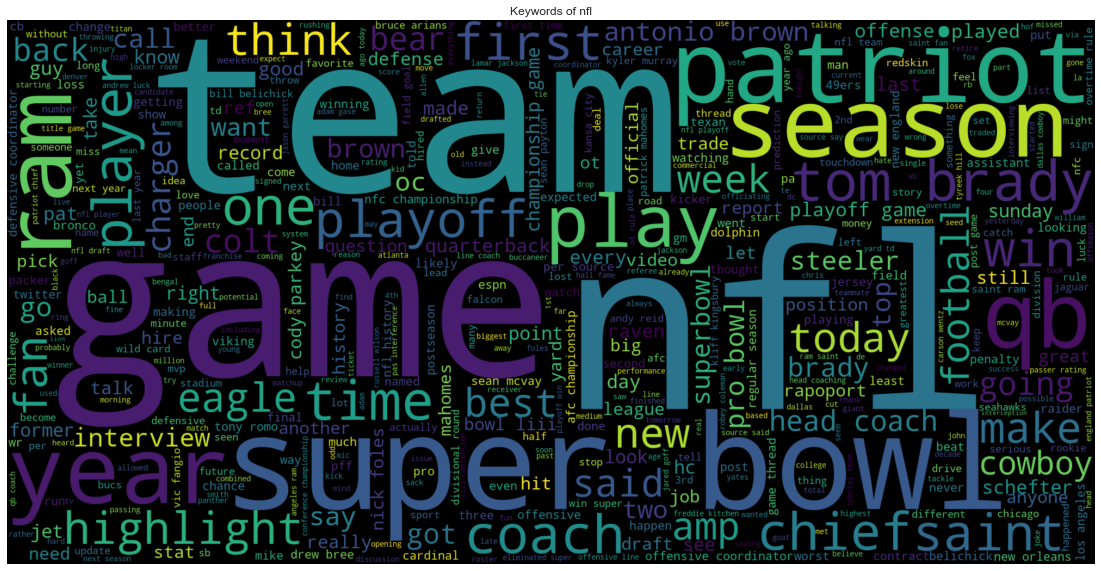

In [31]:
generate_wordcloud(data, 'nfl')

Some of the top keywords are "nfl", "game", "team" and "super bowl". It seems like the keywords in the nfl subreddit contains more distinctive and exclusive words compared to gaming. However, frequently used terms like 'game' and 'play' could cause conflict as the subreddit, gaming uses these word significantly. 

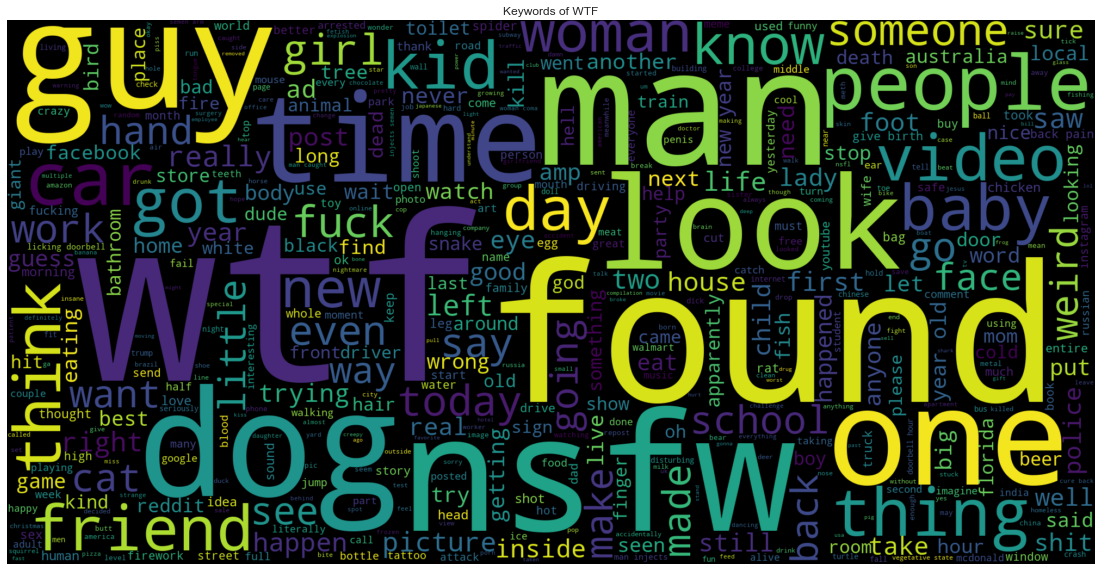

In [32]:
generate_wordcloud(data, 'WTF')

Some of the keywords are 'wtf', 'guy', 'dog', and 'nsfw'. Most of the keywords from subreddits are physical such as guy, man, dog, car, and baby. Even though these terms aren't exclusive to this subreddit, it seems like there are no subreddits that have high frequency of these terms we see in the WTF word cloud. 

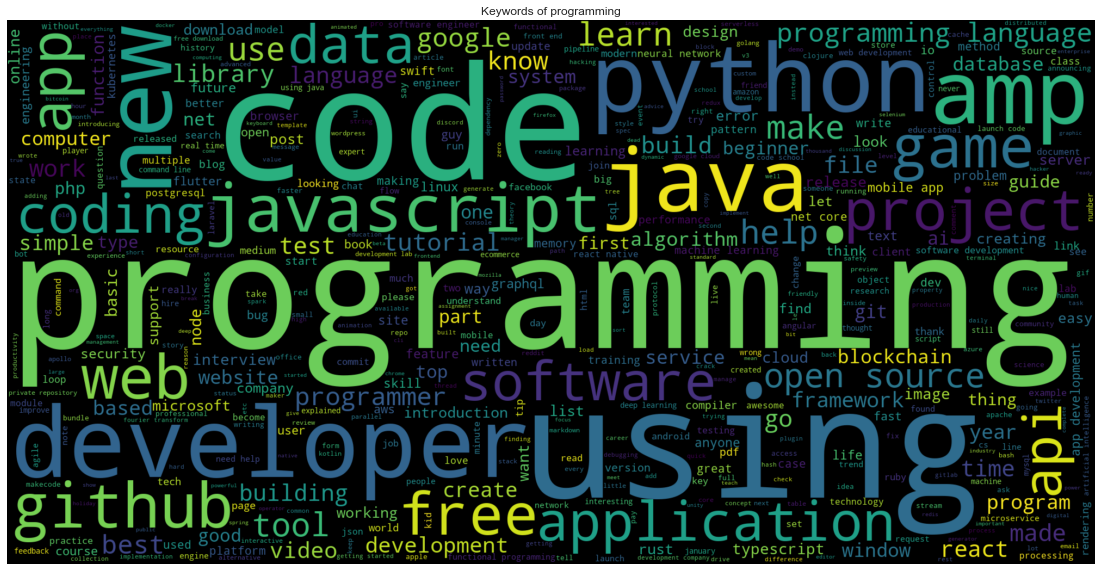

In [33]:
generate_wordcloud(data, 'programming')

In the programming subreddit, the keywords are found to be "programming", "developer", "python" and "code" which are all related to programming. The top keywords seem to be exclusive to the programming subreddit which is a good sign.

### Number of Comments

The variable, num_comments is simply the number of comments to the post. For number of comments, we will analyze the boxplot of each subreddit and see if there are any distinctive factors between the classes for number of comments.

In [34]:
index

Index(['gaming', 'nfl', 'WTF', 'programming'], dtype='object')

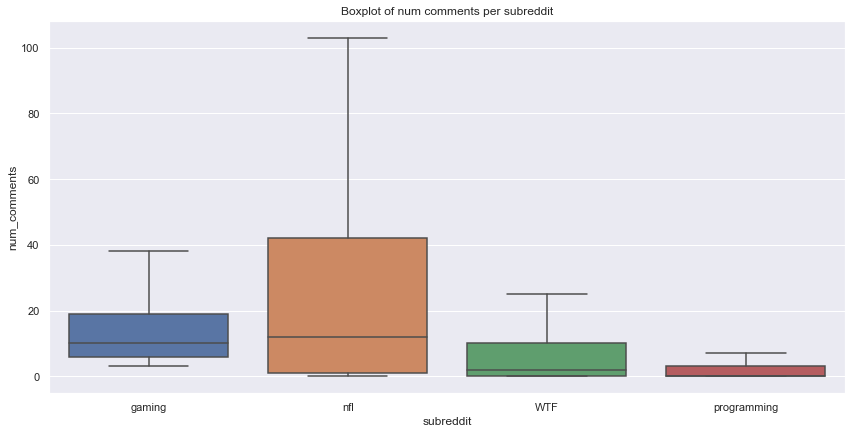

In [35]:
boxplot('subreddit', 'num_comments', data, index, 0)
plt.title("Boxplot of num comments per subreddit")
plt.show()

Based on the boxplots, it seems like the NFL subreddit shows the highest number of comments per posts despite gaming having the substantially larger amount of total postings. This tells us that there are huge pool of users that do not frequently post on NFL subreddit, but still write comments on the posts. Also, in gaming, the topic that could be talked about is huge meaning a lot of the posts may not captivate everyone's interest resulting in low number of comments.

While disregarding the outliers, the number of comments seem to show different characteristics between each subreddits. This feature will be used for the classification tasks. 

The outliers are not going to be removed, because postings that have high number of comments could also reflect on the popularity of the subreddit. 

In [36]:
num_comments = data['num_comments'].copy()

### Score

The variable score is the sum of 'ups' and 'downs' of the postings. For the score, we will analyze the boxplot of each subreddit and observe for any patterns.

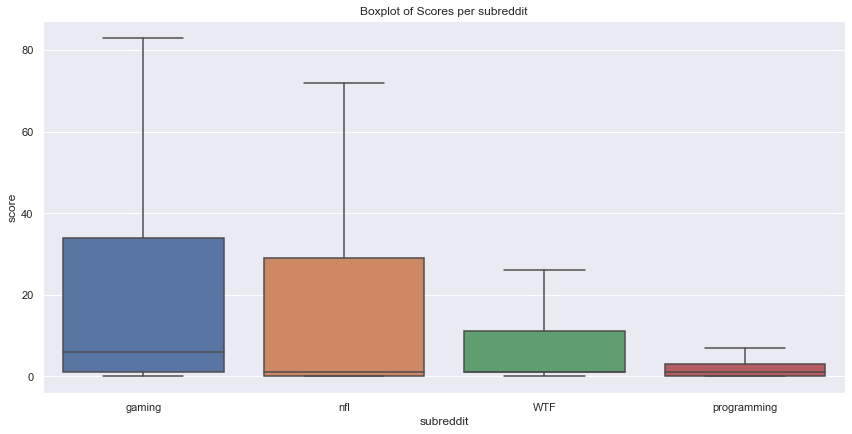

In [38]:
boxplot('subreddit', 'score', data, index, 0)
plt.title("Boxplot of Scores per subreddit")
plt.show()

It seems like the score for gaming and nfl is very similar, but for other subreddits, it shows different chracteristics. Therefore, we will still include scores in the classification tasks.

The outliers are not going to be removed, because postings that have high score could also reflect on the popularity of the subreddit. 

In [39]:
score = data['score']

### Self Text 

The variable selftext is the body of the posting. This may contain useful information. In this variable, there are four types of data which are text, '[removed]', '[deleted]' and blank. We will treat this as categorical data and analyze for any patterns of each category against the four subreddits. 

In [40]:
# Removed Postings
a = data['subreddit'].value_counts(normalize = True)
b = data[data['selftext']=='[removed]']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'Removed':b}))
print ("Total Number: ",len(data[data['selftext']=='[removed]']['subreddit']))

             Subreddits   Removed
WTF            0.147045       NaN
gaming         0.602456  0.323905
nfl            0.158600  0.676095
programming    0.091899       NaN
Total Number:  2192


In [41]:
# Deleted Postings
b = data[data['selftext']=='[deleted]']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'Deleted Posting':b}))
print ("Total Number: ",len(data[data['selftext']=='[deleted]']['subreddit']))

             Subreddits  Deleted Posting
WTF            0.147045         0.310323
gaming         0.602456         0.463445
nfl            0.158600         0.158456
programming    0.091899         0.067775
Total Number:  6374


In [42]:
#Blank Postings
b = data[data['selftext']=='']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'Blank Posting':b}))
print ("Total Number: ",len(data[data['selftext']=='']['subreddit']))

             Subreddits  Blank Posting
WTF            0.147045       0.162331
gaming         0.602456       0.566498
nfl            0.158600       0.124437
programming    0.091899       0.146734
Total Number:  17760


In [43]:
b = data[(data['selftext']!='') & (data['selftext']!='[deleted]') & (data['selftext']!='[removed]')]['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'Text Posting':b}))
print ("Total Number: ", len(data[(data['selftext']!='') & (data['selftext']!='[deleted]') & (data['selftext']!='[removed]')]['subreddit']))

             Subreddits  Text Posting
WTF            0.147045           NaN
gaming         0.602456      0.919638
nfl            0.158600      0.080362
programming    0.091899           NaN
Total Number:  6732


The blank and deleted postings do not have strong relationship amongst the four subreddits, but for removed postings and postings in text, there are clear relationship. For removed postings, nfl had a very high distribution despite having significantly lower overall count. As for text postings, it seems like most of the text postings are from gaming and other sub-reddits have very low distribution or none of text postings.

Also, the text posting can also be broken down and featurized for each words, but based on the normalized results above, the text postings are dominant by gaming subreddit. It seems like featurizing each word may not add significant value, but be computationally expensive.

Overall, this variable seems to have a pattern between the type of postings and the subreddit. Therefore, we will include this variable in our study.

For converting this variable into categorical data, one hot encoding will be used. One hot encoding removes integer encoded variable and a new binary variable is added for unique values. Every value for each feature will become a new column.

In [44]:
selftext_data = data['selftext'].copy()

In [45]:
#Change names of the categories
selftext_data[(selftext_data!='') & (selftext_data!='[deleted]') & (selftext_data!='[removed]')] = 'text'
selftext_data[selftext_data =='[removed]'] = 'removed'
selftext_data[selftext_data =='[deleted]'] = 'deleted'
selftext_data[selftext_data ==''] = 'blank'

In [46]:
#One hot encode
selftext = pd.get_dummies(selftext_data)
selftext.head()

,blank,deleted,removed,text
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


### URL

The variable url contains the link attached to the post. This is very useful, because some subredddits extensively link a specific website. For example, on NFL subreddit, since a lot of the players and the team organization use Twitter, there are a lot of links directing from NFL subreddit to Twitter. Therefore, we will parse the major domain from the external links and convert them as categorical data.

In [47]:
#Extract the domain from the url
from urllib.parse import urlparse

def url_parse(url):
    domain = urlparse(url).netloc
    
    return domain

In [48]:
data['url_domain'] = data['url'].apply(lambda x: url_parse(x))

In [49]:
data['url_domain'].value_counts()

www.reddit.com                                     11510
i.redd.it                                          10568
twitter.com                                         1117
i.imgur.com                                         1043
v.redd.it                                            988
www.youtube.com                                      939
youtu.be                                             889
imgur.com                                            848
gfycat.com                                           457
github.com                                           238
medium.com                                           221
streamable.com                                       141
mobile.twitter.com                                    70
profootballtalk.nbcsports.com                         64
www.espn.com                                          51
www.clippituser.tv                                    49
www.google.com                                        46
www.nfl.com                    

Since the data is sparse, we will impute domains with < 15 counts with 'other'.

In [50]:
#Impute the url domains with less than 15 with 'other'
count = data['url_domain'].value_counts()
idx = count.index[count < 15]

data.loc[data['url_domain'].isin(idx), 'url_domain'] = "other"

In [51]:
data['url_domain'].value_counts()

www.reddit.com                                     11510
i.redd.it                                          10568
other                                               3325
twitter.com                                         1117
i.imgur.com                                         1043
v.redd.it                                            988
www.youtube.com                                      939
youtu.be                                             889
imgur.com                                            848
gfycat.com                                           457
github.com                                           238
medium.com                                           221
streamable.com                                       141
mobile.twitter.com                                    70
profootballtalk.nbcsports.com                         64
www.espn.com                                          51
www.clippituser.tv                                    49
www.google.com                 

We will analyze the top 5 domains in the list above and seek for patterns.

In [52]:
a = data['subreddit'].value_counts(normalize = True)
b = data[data['url_domain']=='www.reddit.com']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'www.reddit.com':b}))

             Subreddits  www.reddit.com
gaming         0.602456        0.789227
nfl            0.158600        0.204431
WTF            0.147045        0.003215
programming    0.091899        0.003128


Most of the times when the postings are simple text postings with no external link, the url in the dataset is the url of its own. By extracting the subreddit from the posting url will certainly provide us with the label or the classes, but that would be somewhat cheating since we are adding direct classes as a feature. Therefore, only the domain is extracted from the reddit.com url. 

As for the distribution, from the previous analysis above, we observed most of the text postings as gaming. This is why the gaming has the highest reddit domain link and the WTF and programming has minimal.

In [53]:
b = data[data['url_domain']=='i.redd.it']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'i.redd.it':b}))

             Subreddits  i.redd.it
WTF            0.147045   0.196726
gaming         0.602456   0.742146
nfl            0.158600   0.035958
programming    0.091899   0.025170


i.reddit.it is a link for images within reddit. We can see that gaming utilizes the images a lot. Also, WTF subreddit also has a large portion of image postings.

In [54]:
b = data[data['url_domain']=='other']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'other':b}))

             Subreddits     other
WTF            0.147045  0.141053
gaming         0.602456  0.150376
nfl            0.158600  0.163609
programming    0.091899  0.544962


For 'other' domain, programming has the highest distribution despite having the least subreddit postings. This is because links related to programming is diverse compared to WTF, gaming and nfl where they have limited domains like Imgur and Twitter which they frequently use from. 

In [55]:
b = data[data['url_domain']=='twitter.com']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'twitter.com':b}))

             Subreddits  twitter.com
WTF            0.147045     0.025067
gaming         0.602456     0.007162
nfl            0.158600     0.943599
programming    0.091899     0.024172


As expected, for Twitter, nfl is dominant in terms of distribution. This is mainly because Twitter is widely used throughout players and the team organization to communicate to the fans. Therefore, the subreddit of NFL has a high frequency of Twitter links.

In [56]:
b = data[data['url_domain']=='i.imgur.com']['subreddit'].value_counts(normalize = True)
print (pd.DataFrame({'Subreddits': a, 'i.imgur.com':b}))


             Subreddits  i.imgur.com
WTF            0.147045     0.293384
gaming         0.602456     0.650048
nfl            0.158600     0.046980
programming    0.091899     0.009588


i.imgur.com is a website for posting images and videos. A lot of the WTF subreddit links to the imgur for sharing videos and images as well as gaming. These two have large content of sharing videos and images as opposed to nfl and programming.

Overall, there are apparent trends between the domain and the subreddits. Adding this variable would add value to the model. Similar to selftext, we will one hot encode this variable.

In [57]:
#One hot encode
url = pd.get_dummies(data['url_domain'])
url.head()

,arstechnica.com,bleacherreport.com,dev.to,gfycat.com,github.com,hackernoon.com,i.imgur.com,i.redd.it,images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com,imgur.com,...,www.nfl.com,www.pcgamer.com,www.pro-football-reference.com,www.profootballfocus.com,www.reddit.com,www.si.com,www.theringer.com,www.youtube.com,www.zeroequalsfalse.press,youtu.be
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Part 3: Classification

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score,f1_score

### 3.1 Feature Extraction & Model Implementation

For classification, the strategy is to determine the ideal parameters for the following:

1. Bag of Words vs TF-IDF
2. The optimal set of features (Use partially or all)
3. The optimal classifier
4. The hyperparameter of the optimal classifier

The best way would be to do gridsearch with CV as it models for all possible options above with the 5-fold cross validation. However, it is going to be computationally expensive. Therefore, we will perform each steps one by one and carry the ideal parameters to the following studies. The cross validation of 5 fold will be applied to help eliminate overfitting and allow the model to use the entire data.

For step 1 and 2, logistic regression is used, because it is a simple and computationally inexpensive classifier. Logistic regression is commmonly used as a baseline classifier.




As for the metric, the three metrics will be analyzed which are:

1. Accuracy - Accuracy is the measure of all the correctly identified predictions. Accuracy determines how well the model predicts in general.
2. Precision - Since the major concerns are the false positives in this application, precision will be analyzed 
3. F1 Score - F1 score(macro) is the combination of precision and recall. F1 score generally provides a better measure of incorrectly predicted classes and is very useful in imbalanced data. 



The three metrics will be analyzed; however, since the data is imbalanced, F1 score metric will most concisely provide us with how well the model generalized. Therefore, for selecting the optimal parameters and features, F1 score will be highly prioritized, but won't be solely used to make decisions

### Step 1 - Bag of Words vs TF-IDF

In [59]:
X_BoW = title_BoW.copy()
X_tf = title_tf.copy()
y = data['subreddit']

#List of Feature sets to Train with
feature_extraction = []
feature_extraction.append(('BOW', X_BoW))
feature_extraction.append(('TF-IDF', X_tf))

#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))

In [60]:
def cross_val_dataset (df_set,model_set, model_var = False):
    result = pd.DataFrame(index = ['Accuracy', 'Precision', 'F1 Score'])
    kfold = KFold(n_splits = 5)
    
    for classifier, model in models:
        for feature_set, X in df_set:

            accuracy = np.zeros(5)    
            precision = np.zeros(5)
            f1 = np.zeros(5)
            np_idx = 0

            for train_idx, test_idx in kfold.split(X):

                X_train, X_test = X.loc[train_idx], X.loc[test_idx]
                y_train, y_test = y.loc[train_idx], y.loc[test_idx]

                model.fit(X_train,y_train)

                y_test_pred = model.predict(X_test)

                ACC = accuracy_score(y_test,y_test_pred)*100
                P = precision_score(y_test,y_test_pred, average='macro')*100
                F1 = f1_score(y_test, y_test_pred, average = 'macro') *100

                accuracy[np_idx] = ACC
                precision[np_idx] = P
                f1[np_idx] = F1

                np_idx +=1
        
            if (model_var !=True):
                result[feature_set] = [round(np.mean(accuracy),3), round(np.mean(precision),3), round(np.mean(f1),3)] 
            else:
                result[classifier] = [round(np.mean(accuracy),3), round(np.mean(precision),3), round(np.mean(f1),3)]  
            
    return result

In [61]:
result_feature_extraction = cross_val_dataset(feature_extraction,models, model_var = False)

In [62]:
result_feature_extraction

,BOW,TF-IDF
Accuracy,82.643,81.989
Precision,83.449,84.690
F1 Score,76.351,74.962


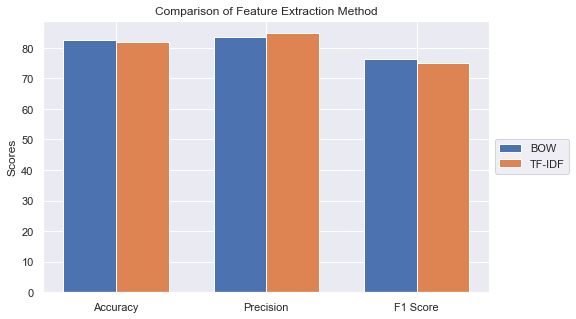

In [63]:
grouped_bargraph(result_feature_extraction, "Comparison of Feature Extraction Method")

The results indicate that the bag of words tend to provide better results for F1 score and accuracy. Therefore, bag of words method will be chosen for further studies.

### Step 2 - Set of Features

For this step, we will analyze feature set as follows:

1. Title
2. Title, URL & Selftext
3. Title, URL, Selftext, Score & Number of Comments

For every new set, the next two important features based on EDA were added.


In [64]:
X_1 = pd.concat([title_BoW], axis = 1, sort=False)
X_2 = pd.concat([title_BoW, url,selftext], axis = 1, sort=False)
X_3 = pd.concat([title_BoW, url,selftext, num_comments, score], axis = 1, sort=False)

In [92]:
#List of Feature sets to Train with
set_of_features = []
set_of_features.append(('X1', X_1))
set_of_features.append(('X2', X_2))
set_of_features.append(('X3', X_3))

In [93]:
result_feature_set = cross_val_dataset(set_of_features, models, model_var = False)

In [94]:
result_feature_set

,X1,X2,X3
Accuracy,82.643,87.939,87.265
Precision,83.449,86.716,86.056
F1 Score,76.351,84.182,82.817


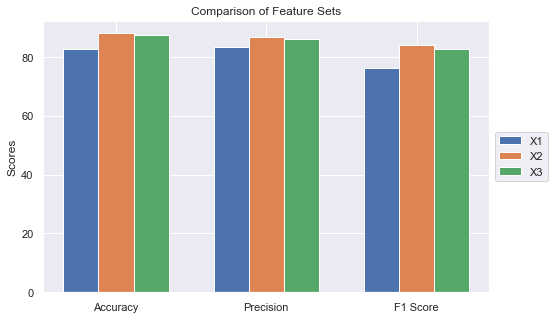

In [95]:
grouped_bargraph(result_feature_set, "Comparison of Feature Sets")

For the feature sets, it is clear that the X_2 dataset which contains the title, url, and selftext as the features yield the best result. From the EDA, we were able to see a strong trend for these variables, but for number of comments and scores, the trend was weaker. Therefore, for further studies, the featureset X2 will be used.

### Step 3 Model Selection

In [96]:
#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('SVM', LinearSVC()))

features = []
features.append(('Features', X_2))

In [97]:
result_model = cross_val_dataset(features,models, model_var = True)

In [98]:
result_model

,Logistic Regression,Naive Bayes,SVM
Accuracy,87.939,87.325,87.779
Precision,86.716,84.890,85.651
F1 Score,84.182,84.770,84.129


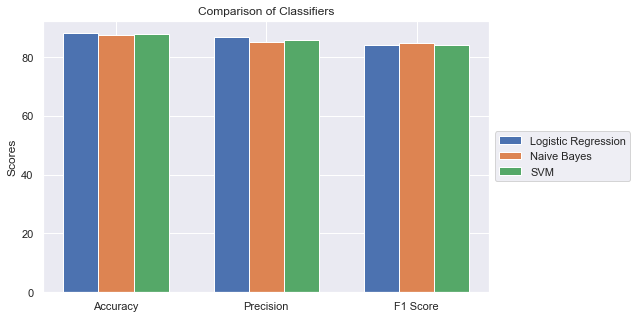

In [99]:
grouped_bargraph(result_model, "Comparison of Classifiers")

For model selection, Logistic Regression yielded the best result for accuracy and precision, but for F1 score, Multinomial Naive Bayes yielded slightly better. Even though Naive Bayes resulted in the best F1 score, logistic regression will be used for further studides, because logistic regression is a learning algorithm that requires a hyperparameter tuning. For Naive Bayes, even though there is learning, the algorithm does not have regularization. Therefore, it's less sensitive to the hyperparameters. Since the F1 score of Naive Bayes is slightly better compared to logistic regression, logistic regression may outperform Naive Bayes when tuned. 

### Step 4 Hyperparameter Tuning

In [61]:
def grid_search_cv (df_set):
    result = pd.DataFrame()
    kfold = KFold(n_splits = 5)
    best_f1 = 0
    X = df_set.copy()
    
    for solver in tqdm(['newton-cg','lbfgs','liblinear','sag']):
                
        for C in [0.001,0.01,0.1,1,5,10]:
            model = LogisticRegression(C=C, solver=solver)
            f1 = np.zeros(5)
            np_idx = 0

            for train_idx, test_idx in kfold.split(X):

                X_train, X_test = X.loc[train_idx], X.loc[test_idx]
                y_train, y_test = y.loc[train_idx], y.loc[test_idx]

                model.fit(X_train,y_train)
                y_test_pred = model.predict(X_test)

                F1 = f1_score(y_test, y_test_pred, average = 'macro') *100
                f1[np_idx] = F1
                np_idx +=1
                                
            if np.mean(f1) > best_f1:
                best_model = model
                best_params = {'C':C, 'solver':solver}
                best_f1 = np.mean(f1)
                
    return best_params,best_f1

In [122]:
best_params,best_f1, result = grid_search_cv(X_2)

In [135]:
print("The Best parameter was found to be: {} with f1 score of {}".format(best_params,round(best_f1,2)))

The Best parameter was found to be: {'C': 5, 'solver': 'sag'} with f1 score of 84.64


### 3.2 Results

In [55]:
model = LogisticRegression(C = 5, solver = 'sag')

### F1 Score over Folds

In [64]:
def cross_val_results (X,y,model):
    kfold = KFold(n_splits = 5)
    f1_train = np.zeros(5)
    f1_test = np.zeros(5)
    np_idx = 0


    for train_idx, test_idx in kfold.split(X):

        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]

        model.fit(X_train,y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        F1_train = f1_score(y_train,y_train_pred, average = 'macro') * 100
        F1_test = f1_score(y_test, y_test_pred, average = 'macro') * 100
        f1_train[np_idx] = F1_train
        f1_test[np_idx] = F1_test
        np_idx +=1
    
    return f1_train,f1_test 

In [68]:
f1_train,f1_test = cross_val_results (X_2,y,model)

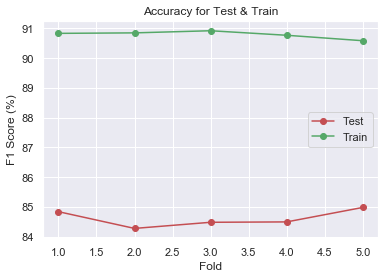

In [74]:
plt.plot(range(1,6),f1_test,'o-', color="r",label="Test")
plt.plot(range(1,6), f1_train, 'o-', color="g", label="Train")
plt.legend(loc="best")
plt.title("Accuracy for Test & Train")
plt.xlabel("Fold")
plt.ylabel("F1 Score (%)")
plt.show()

For test set, the F1-score of each fold seems to not fluctuate significantly. This tells us that the model is able to generalize and is not sensitive to which data it gets used to train. 

### Final Model Implementation

For the final prediction, we will use all the parameters above and split the dataset into test and train. Train data will be used for training and test data will be used to validate the model.

In [65]:
from sklearn.model_selection import train_test_split

#Split Train & Test
X_train,X_test,y_train,y_test = train_test_split(X_2,y, test_size = 0.30, random_state = 5)

In [66]:
model = LogisticRegression(C = 5 , solver = 'sag')

model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


train_f1 = f1_score(y_train, y_train_pred, average = 'macro')*100
test_f1 = f1_score(y_test, y_test_pred, average = 'macro') *100

train_precision = precision_score(y_train, y_train_pred, average = 'macro')*100
test_precision = precision_score(y_test, y_test_pred, average = 'macro') *100

train_accuracy= accuracy_score(y_train, y_train_pred)*100
test_accuracy = accuracy_score(y_test, y_test_pred) *100


In [86]:
result = pd.DataFrame([[train_accuracy,train_precision,train_accuracy],[test_f1,test_precision,test_accuracy]], 
                      columns = ['Accuracy','Precision','F1 Score'],
                      index = ['Train','Test'])

In [87]:
result

,Accuracy,Precision,F1 Score
Train,93.059637,93.023880,93.059637
Test,84.467800,86.741461,87.830208


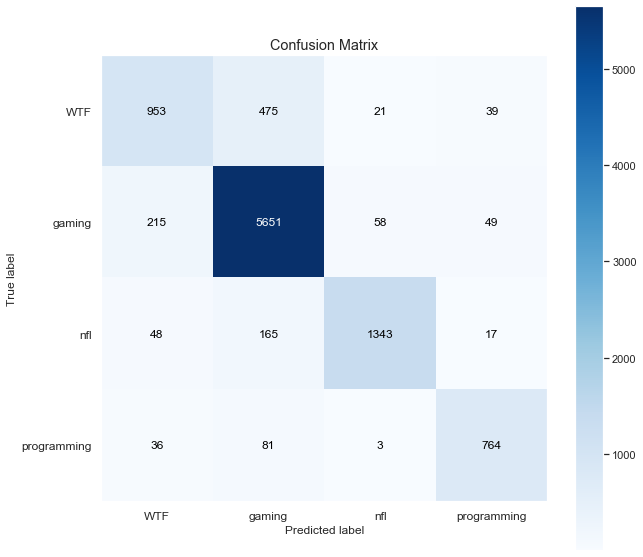

In [89]:
#Plot Confusion Matrix
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test.values, 
    y_test_pred,
    figsize=(10,10))


plt.show()

The F1 score of the test and train data were computed as 87.83% and 93.06% respectively. 

From hyperparameter tuning, the optimal parameters are determined for maximizing the F1 score; however, in return the accuracy slightly went down. Since the class is imbalanced, F1 score is the best metric to evaluate the model.

Troughout each fold of the model with optimal parameters, the variances of f1 score are low meaning the model generalizes well and does not get affected heavily by which data it uses to train.

Based on the confusion matrix, model predicts the nfl, programming and gaming subreddits very well. From the EDA, we saw a very strong trend for few features for these subreddits which allowed for a great performance. For the WTF subreddit, it relatively performs poor compared to the other three subreddits. This is because of lack of distinctive information and diverse topic the WTF subreddit could cover. We could observe that the model predicted gaming instead of WTF quite frequently. This is due to the dominant distribution of gaming subreddits. 

Overall, the model has a great performance on predicting the labels and has generalized well. The next step on improving the model are as follows:

* Apply different methods for data processing such as stemming instead of lemmatization.
* Analyze different feature extraction methods like N-Gram
* Analyze the optimal number of words to featurize from TF-IDF or other methods
* Analyze more complex models like neural network
* Determine ways to extract more information/features for WTF subreddit
* Get balanced data

## Part 4: Sentiment Analysis

In [72]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

In [73]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [74]:
titles = data['title'].values

In [75]:
titleDF = evalSentences(titles, to_df=True, columns=['reviewCol','vader'])

In [76]:
titleDF['subreddit'] = data['subreddit']
titleDF.head()

,reviewCol,vader,subreddit
0,What are some game games to enjoy on a low-end...,0.4939,gaming
1,Xbox 1 s controller not discovered via bluetoo...,0.0000,gaming
2,The local Walmart did not sell even one copy o...,0.0000,gaming
3,What is the best wireless headset for PS4? I k...,0.7076,gaming
4,Happy New Year Gamers,0.5719,gaming


### 4.2 Distribution

In [77]:
def getHistogram(data, title):
        plt.figure(figsize=(12,6))
        plt.hist(data.values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

In [78]:
gaming_vader = titleDF[titleDF['subreddit']=='gaming']['vader']
WTF_vader = titleDF[titleDF['subreddit']=='WTF']['vader']
nfl_vader = titleDF[titleDF['subreddit']=='nfl']['vader']
programming_vader = titleDF[titleDF['subreddit']=='programming']['vader']

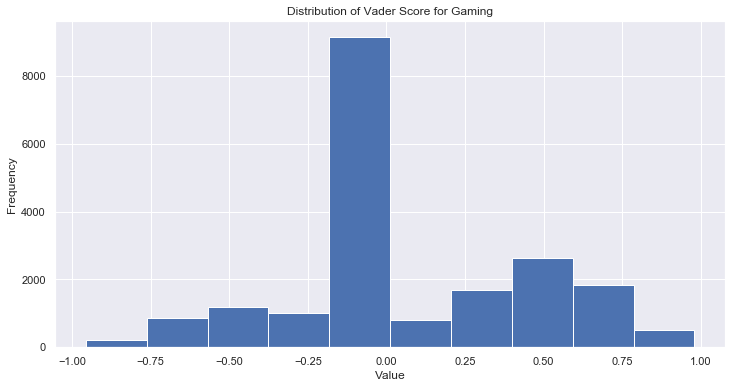

In [79]:
getHistogram(gaming_vader, 'Distribution of Vader Score for Gaming')

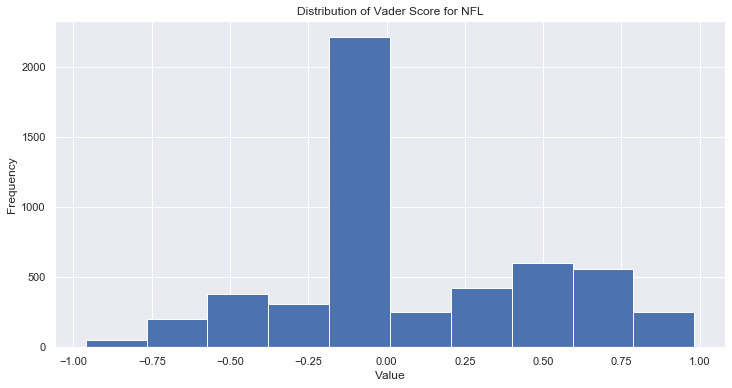

In [80]:
getHistogram(nfl_vader, 'Distribution of Vader Score for NFL')

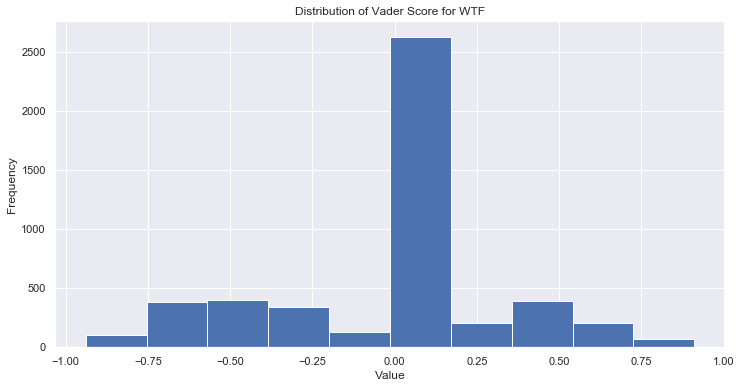

In [81]:
getHistogram(WTF_vader, 'Distribution of Vader Score for WTF')

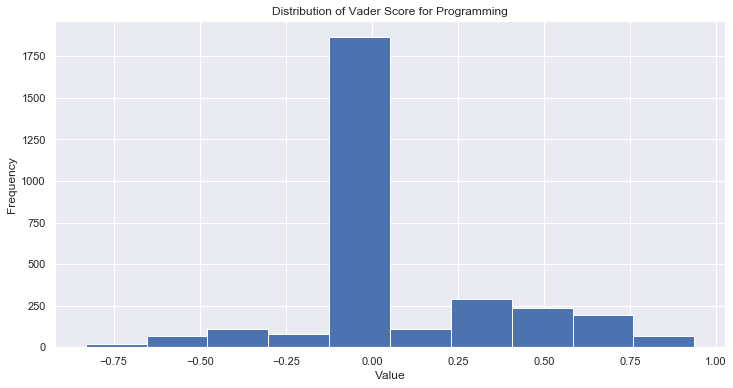

In [82]:
getHistogram(programming_vader, 'Distribution of Vader Score for Programming')

Most of the postings in all subreddits have neutral sentiment in the title. Based on the distribution, we can learn that it is hard to determine the sentiment of the postings based on simply the title of the posting. Also, the sentiment of the posting titles are usually neutral.

As for each subreddits, gaming and nfl has larger distribution for postive sentiment compared to the rest, WTF has the most negative sentiment compared to the rest and programming has the least negative sentiment and highest neutral distribution. 



### 4.3 Sentiment Labels

From the distribution, having the threshhold of <-0.75 and > 0.75 may not have enough data for the analysis. Therefore, the threshhold is chosen as < -0.50 and > 0.50. 

In [83]:
def sentiment_label(vader):
    label = ''
    if vader < -0.75:
        label = 'Negative'
    elif vader > 0.75:
        label = 'Positive'
        
    return label

In [84]:
titleDF['label'] = titleDF['vader'].apply(lambda x: sentiment_label(x))

In [85]:
#Drop rows with empty titles
drop_rows = titleDF[titleDF['label'] ==''].index
titleDF.drop(drop_rows , inplace=True)
titleDF = titleDF.reset_index(drop=True)

In [86]:
titleDF.head()

,reviewCol,vader,subreddit,label
0,Black Friday is probably the best time to buy ...,0.8555,gaming,Positive
1,[Fillipponi] Mike Tomlin is a joke. He was pre...,0.8750,nfl,Positive
2,Week 17 is really either the most exciting gam...,0.7897,nfl,Positive
3,Any good fresh game recommendations preferably...,0.7650,gaming,Positive
4,"Releasing my first game, hope you enjoy some o...",0.8777,gaming,Positive


### 4.4 Top words

For determining the top words, term frequency analysis is performed. There are different methods like pointwise mutual information, but this is not very informative on text with labels. Term frequency allows us to determine the frequently used words in different sentiment values for each subreddit. This would help us identify which topics and aspects the users are either positive about or negative about.

In [87]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(titleDF, k=500):
    reviews = titleDF['reviewCol'].values
        
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop_nltk  and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalDf = titleDF.join(freqReviewDf)
    return topk, finalDf

In [88]:
topk,finalDf = dataFrameTransformation(titleDF, k=500)

In [90]:
finalDf.head()

,reviewCol,vader,subreddit,label,game,best,super,games,play,like,...,die,fighting,already,cowboys,arians,hard,battle,known,gta,gotta
0,Black Friday is probably the best time to buy ...,0.8555,gaming,Positive,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[Fillipponi] Mike Tomlin is a joke. He was pre...,0.8750,nfl,Positive,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Week 17 is really either the most exciting gam...,0.7897,nfl,Positive,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Any good fresh game recommendations preferably...,0.7650,gaming,Positive,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"Releasing my first game, hope you enjoy some o...",0.8777,gaming,Positive,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
def getTopK(df, k, label_value, subreddit, label_column='label', operation=operator.eq, value_column='reviewCol'):
    #Add possible Stop Words for Postings
    stop_nltk = stopwords.words('english')
    counter = Counter()
    subredditDF = df[df['subreddit']==subreddit]
    for review in subredditDF.loc[operation(subredditDF[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop_nltk and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [160]:
def barplot_words (topk, title):
    words = []
    counts = []
    for word, count in topk:
        words.append(word)
        counts.append(count)
        
    plt.figure(figsize=(6,12))
    sns.set(style="darkgrid")
    sns.barplot(x = counts, y= words, orient = 'h')
    plt.xlabel("Count")
    plt.ylabel("")
    plt.title(title)
    plt.show()

### Gaming Subreddit

In [161]:
topk_pos_gaming=getTopK(finalDf, 50, label_value='Positive', subreddit = 'gaming')

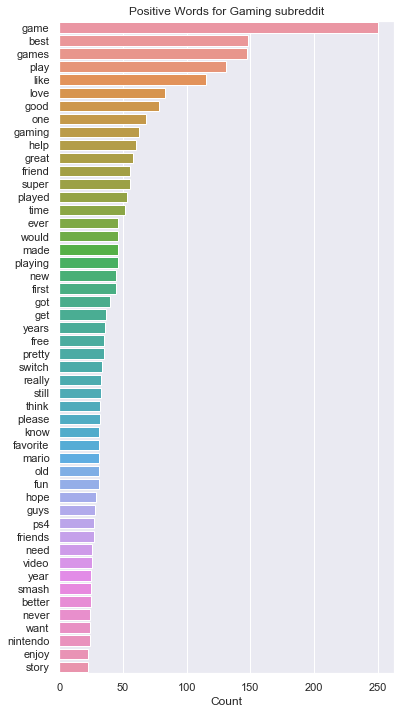

In [162]:
barplot_words(topk_pos_gaming, "Positive Words for Gaming subreddit")

For top words in gaming, we see best, game, play, love and favourite. Most of these words are commonly used words with postive sentiment. In gaming, there are diverse aspects and topics users express the positive sentiment. This is why we see a lot of general postive words.

In [163]:
topk_neg_gaming=getTopK(finalDf, 50, label_value='Negative', subreddit = 'gaming')

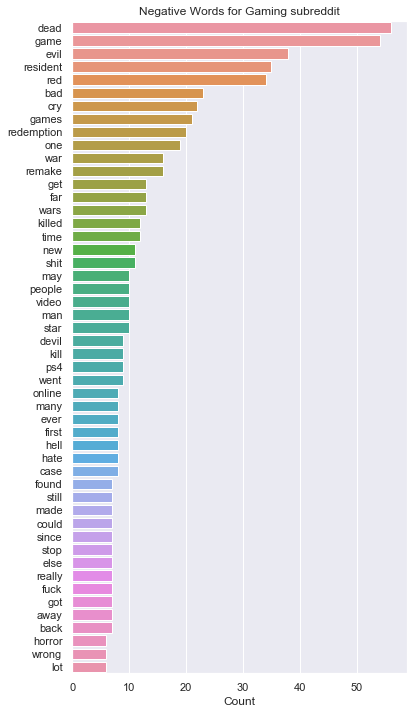

In [164]:
barplot_words(topk_neg_gaming, "Negative Words for Gaming subreddit")

In the negative words for gaming subreddit, a lot of the words are cursing words or words with negative sentiment. Also, another finding is that there are lots and lots of negative postings about a game named "Red Dead Redemption" and "Resident Evil". As for negative gaming subreddit, a lot of the words are general, but the top words of negative postings are specific to the gaming subreddit.

### NFL Subreddit

In [165]:
topk_pos_nfl = getTopK(finalDf, 50, label_value='Positive', subreddit = 'nfl')

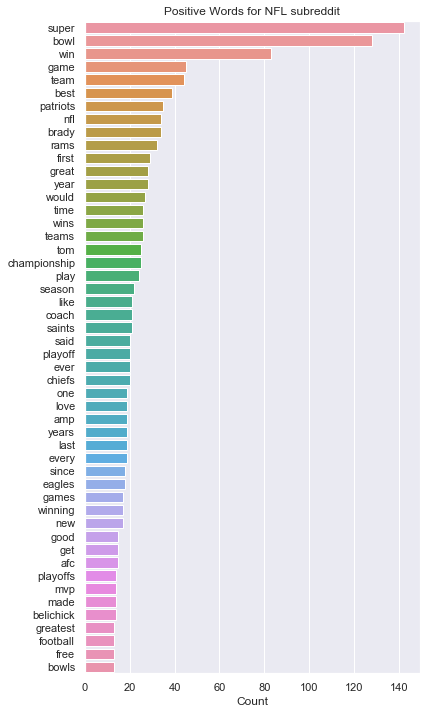

In [170]:
barplot_words(topk_pos_nfl, "Positive Words for NFL subreddit")

For NFL subreddit, the postive words are Super Bowl, the Patriots (Team), Tom Brady, nfl, and the team. As for NFL positive words, there are a lot of words that are specific rather than general unlike the gaming subreddit.

In [171]:
topk_neg_nfl = getTopK(finalDf, 50, label_value='Negative', subreddit = 'nfl')

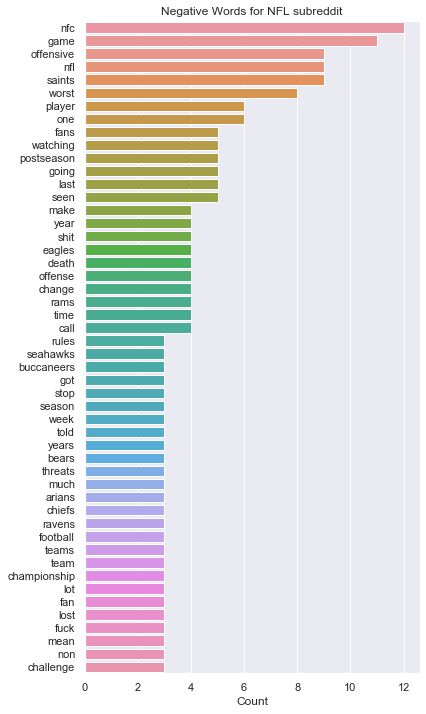

In [172]:
barplot_words(topk_neg_nfl, "Negative Words for NFL subreddit")

As for the top negative sentiment words, nfc, nfl, player, offensive, gamem etc. are identified as the top negative words for NFL subreddit. Also,some common words in negative sentiment include specific teams like Seahawks and Buccaneers. 

### WTF Subreddit

In [173]:
topk_pos_wtf = getTopK(finalDf, 50, label_value='Positive', subreddit = 'WTF')

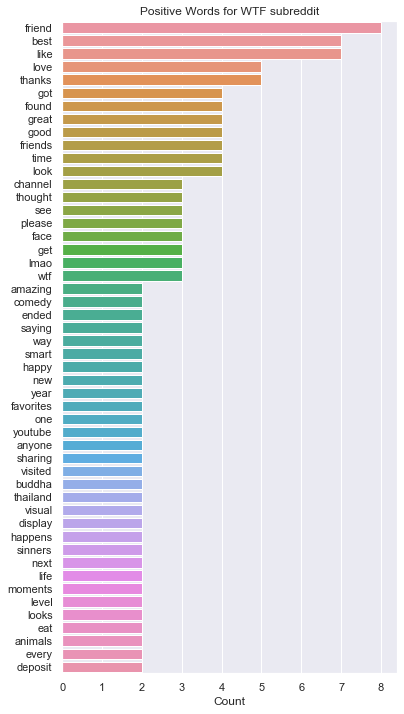

In [175]:
barplot_words(topk_pos_wtf, "Positive Words for WTF subreddit")

As for WTF subreddit, words like friend, best, like love and thanks are identified as the top words for positive postings. As for WTF subreddit, since the subreddit is a broad topic, the positive terms tend to be general and not specific to this subreddit.

In [176]:
topk_neg_wtf = getTopK(finalDf, 50, label_value='Negative', subreddit = 'WTF')

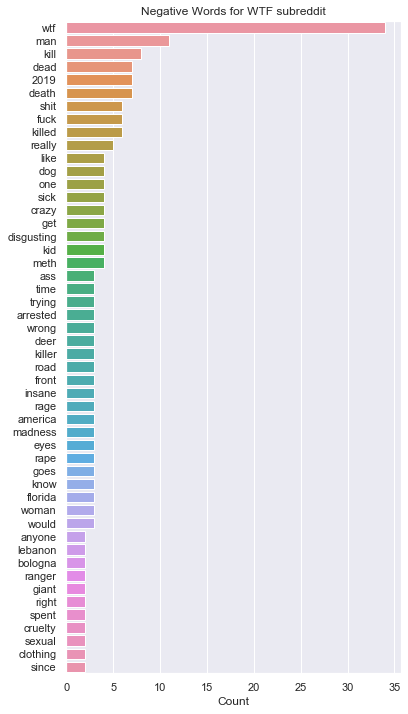

In [177]:
barplot_words(topk_neg_wtf, "Negative Words for WTF subreddit")

Similar pattern is shown in the negative postings. Other than the word, wtf, most words are not specific to this subreddit.

### Programming

In [181]:
topk_pos_prg = getTopK(finalDf, 50, label_value='Positive', subreddit = 'programming')

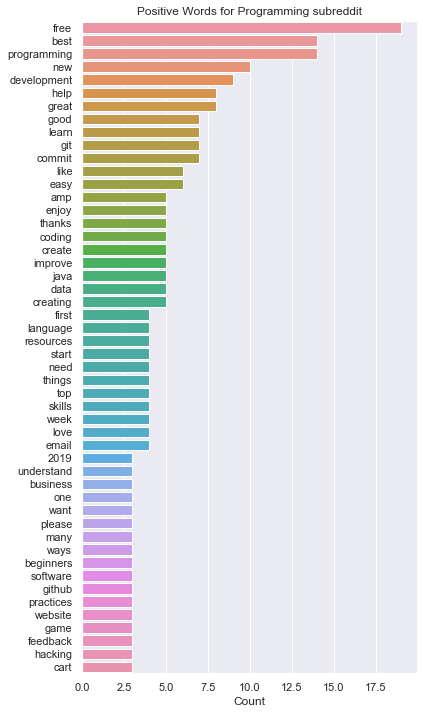

In [182]:
barplot_words(topk_pos_prg, "Positive Words for Programming subreddit")

The top words for programming subreddit are identified to be free, best, programming, new, development. In programming, we see a lot of words that are specific to programming such as git, data, java, github, software and more.. Another observation is that the most common words throughout the postive postings are free. People tend to express positively when something is free. 

In [179]:
topk_neg_prg = getTopK(finalDf, 50, label_value='Negative', subreddit = 'programming')

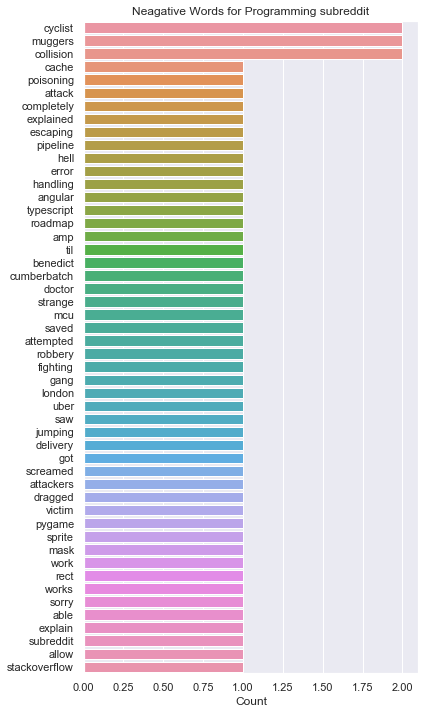

In [183]:
barplot_words(topk_neg_prg, "Neagative Words for Programming subreddit")

As for negative words for programming subreddit, there are cyclist, muggers, collision and more.. Theses words are not really linked to the subreddit. There could have been probably a posting or two that have mentioning of cyclist, muggers and collision. Overall, there aren't a lot of negative postings for programming subreddit which make it hard to identify the patterns.

In summary, we saw the following patterns for each subreddit:
* Gaming subreddit: Most words from positive postings are general, but the words from negative postings are specific to a gaming subreddit.
* NFL subreddit: Words from postive and negative postings are specific to NFL
* WTF subreddit: Words from positive and negative postings are very general.
* Programming subreddit: Words from positive postings are general, but for negative postings, no pattern were able to be found due to lack of data.